Imports

In [1]:
from parameters import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from jitcdde import t
from msrDynamics.objects import Node, System


In [2]:
MSRE = System()

# radiator
T_out_rc = Node(m = mn_rp, scp = mcp_rpn/mn_rp, W = W_rp, y0 = T0_rp)
T_out_air = Node(m = mn_rs, scp = mcp_rsn/mn_rs, W = W_rs, y0 = T0_rs)

# heat exchanger
T_hf1 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p1)
T_hf2 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p2)
T_hf3 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p3)
T_hf4 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p4)
T_ht1 = Node(m = m_tn, scp = scp_t, y0 = T0_t1)
T_ht2 = Node(m = m_tn, scp = scp_t, y0 = T0_t2)
T_hc1 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s1)
T_hc2 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s2)
T_hc3 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s3)
T_hc4 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s4)

# core 
n = Node(y0 = n_frac0)
C1 = Node(y0 = C0[0])
C2 = Node(y0 = C0[1])
C3 = Node(y0 = C0[2])
C4 = Node(y0 = C0[3])
C5 = Node(y0 = C0[4])
C6 = Node(y0 = C0[5])
rho = Node(y0 = 0.0)

# add reactivity input
t_ins = 500
inserted = 5e-4
insert_duration = 0.0
t_wd = 2500
def rho_insert(t):
    if (t<t_ins):
        return 0.0
    # elif (t<(t_ins+insert_duration)):
    #     return ((t-t_ins))*(inserted/insert_duration) # linear
    # elif (t < t_wd):
    #     return inserted
    # elif (t < t_wd+insert_duration):
    #     return inserted-((t-t_wd))*(inserted/insert_duration) # linear
    else:
        return inserted

rho_ext =MSRE.add_input(rho_insert, T)

T_cg = Node(m = mcp_g1/scp_g, scp = scp_g, y0 = T0_g1)
T_cf1 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)
T_cf2 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)

MSRE.add_nodes([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
               T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

# dynamics 

# radiator
T_out_rc.set_dTdt_advective(source = T_hc4.y(t-tau_hx_r))
T_out_rc.set_dTdt_convective(source = [T_out_air.y()], hA = [hA_rpn])

T_out_air.set_dTdt_advective(source = Trs_in)
T_out_air.set_dTdt_convective(source = [T_out_rc.y()], hA = [hA_rsn])

# heat exchanger
T_hf1.set_dTdt_advective(source = T_cf2.y(t-tau_c_hx))
T_hf1.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

T_hf2.set_dTdt_advective(source = T_hf1.y())
T_hf2.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

T_hf3.set_dTdt_advective(source = T_hf2.y())
T_hf3.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

T_hf4.set_dTdt_advective(source = T_hf3.y())
T_hf4.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf2.y(),T_hc3.y(),T_hc4.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf4.y(),T_hc1.y(),T_hc2.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])

T_hc1.set_dTdt_advective(source = T_out_rc.y(t-tau_r_hx))
T_hc1.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

T_hc2.set_dTdt_advective(source = T_hc1.y())
T_hc2.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

T_hc3.set_dTdt_advective(source = T_hc2.y())
T_hc3.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

T_hc4.set_dTdt_advective(source = T_hc3.y())
T_hc4.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

# core
n.set_dndt(r = rho.y()+rho_ext, beta_eff = beta_t, Lambda = Lam, lam = lam, C = [C1.y(),C2.y(),C3.y(),C4.y(),C5.y(),C6.y()])
C1.set_dcdt(n.y(),beta[0],Lam,lam[0],tau_c,tau_l)
C2.set_dcdt(n.y(),beta[1],Lam,lam[1],tau_c,tau_l)
C3.set_dcdt(n.y(),beta[2],Lam,lam[2],tau_c,tau_l)
C4.set_dcdt(n.y(),beta[3],Lam,lam[3],tau_c,tau_l)
C5.set_dcdt(n.y(),beta[4],Lam,lam[4],tau_c,tau_l)
C6.set_dcdt(n.y(),beta[5],Lam,lam[5],tau_c,tau_l)

T_cg.set_dTdt_convective(source = [T_cf1.y()], hA = [hA_fg])
T_cg.set_dTdt_internal(source = n.y(), k = k_g*P)

T_cf1.set_dTdt_advective(source = T_hf4.y(t-tau_hx_c))
T_cf1.set_dTdt_convective(source = [T_cg.y()], hA = [k_1*hA_fg])
T_cf1.set_dTdt_internal(source = n.y(), k = k_f1*P)

T_cf2.set_dTdt_advective(source = T_cf1.y())
T_cf2.set_dTdt_convective(source = [T_cg.y()], hA = [k_2*hA_fg])
T_cf2.set_dTdt_internal(source = n.y(), k = k_f2*P)

rho.set_drdt(sources = [T_cf1.dydt(), T_cf2.dydt(), T_cg.dydt()], coeffs = [a_f/2,a_f/2,a_g])

In [3]:
# MSRE.get_dydt()

In [4]:
sol_jit = MSRE.solve(T)

finalized
Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

Text(0.5, 1.0, '$\\rho$')

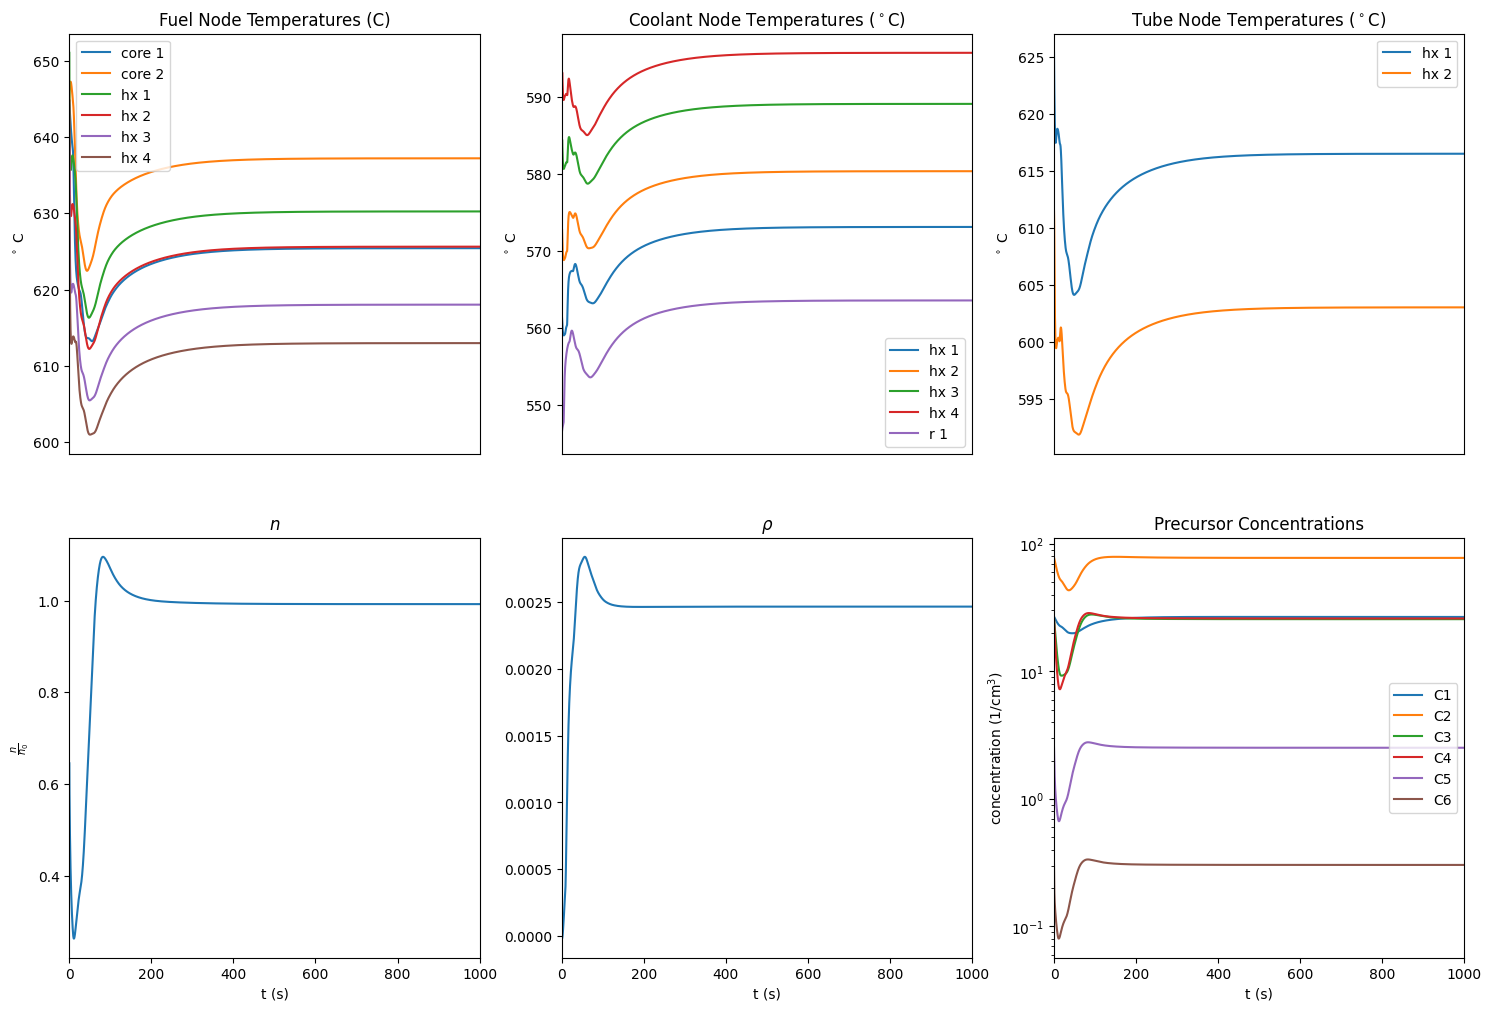

In [5]:
fig,axs = plt.subplots(2,3,figsize=(18,12))

t0 = 0
tf = 1000

# fuel temps
axs[0,0].set_xlim([t0,tf])
axs[0,0].set_ylabel(r"$^\circ$ C")
axs[0,0].plot(T,[s[20] for s in sol_jit],label="core 1") 
axs[0,0].plot(T,[s[21] for s in sol_jit],label="core 2") 
axs[0,0].plot(T,[s[2] for s in sol_jit],label="hx 1")  
axs[0,0].plot(T,[s[3] for s in sol_jit],label="hx 2")
axs[0,0].plot(T,[s[4] for s in sol_jit],label="hx 3")
axs[0,0].plot(T,[s[5] for s in sol_jit],label="hx 4")  
axs[0,0].legend()
axs[0,0].set_title("Fuel Node Temperatures (C)")
axs[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# coolant temps
axs[0,1].set_xlim([t0,tf])
axs[0,1].set_ylabel(r"$^\circ$ C")
axs[0,1].plot(T,[s[8] for s in sol_jit],label="hx 1") 
axs[0,1].plot(T,[s[9] for s in sol_jit],label="hx 2") 
axs[0,1].plot(T,[s[10] for s in sol_jit],label="hx 3")  
axs[0,1].plot(T,[s[11] for s in sol_jit],label="hx 4")
axs[0,1].plot(T,[s[0] for s in sol_jit],label="r 1")
axs[0,1].legend()
axs[0,1].set_title(r"Coolant Node Temperatures ($^\circ$C)")
axs[0,1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# tube node temps
axs[0,2].set_xlim([t0,tf])
axs[0,2].set_ylabel(r"$^\circ$ C")
axs[0,2].plot(T,[s[6] for s in sol_jit],label="hx 1") 
axs[0,2].plot(T,[s[7] for s in sol_jit],label="hx 2") 
axs[0,2].legend()
axs[0,2].set_title(r"Tube Node Temperatures ($^\circ$C)")
axs[0,2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# precursor concentrations
axs[1,2].set_xlim([t0,tf])
axs[1,2].plot(T,[s[13] for s in sol_jit],label="C1") 
axs[1,2].plot(T,[s[14] for s in sol_jit],label="C2") 
axs[1,2].plot(T,[s[15] for s in sol_jit],label="C3")  
axs[1,2].plot(T,[s[16] for s in sol_jit],label="C4")
axs[1,2].plot(T,[s[17] for s in sol_jit],label="C5")
axs[1,2].plot(T,[s[18] for s in sol_jit],label="C6")
axs[1,2].legend()
axs[1,2].set_xlabel("t (s)")
axs[1,2].set_yscale("log")
axs[1,2].set_ylabel(r"concentration (1/cm$^3$)")
axs[1,2].legend(loc="right")
axs[1,2].set_title("Precursor Concentrations")

# multiplication factor temp
axs[1,0].set_xlim([t0,tf])
axs[1,0].plot(T[10:],n.y_out[10:],label="n") 
axs[1,0].set_xlabel("t (s)")
axs[1,0].set_title(r"$n$")
axs[1,0].set_ylabel(r"$\frac{n}{n_0}$")

# reactivity
axs[1,1].set_xlim([t0,tf])
axs[1,1].plot(T,[s[22] for s in sol_jit],label="n") 
axs[1,1].set_xlabel("t (s)")
axs[1,1].set_title(r"$\rho$")

#plt.figure(figsize=(8,6))
#plt.plot(T,[s[12] for s in sol_jit],label=r"$(\alpha_f,\alpha_g) = $ (-8.71,-6.66) pcm")
#plt.plot(T,[s[12] for s in sols[1]],label=r"$(\alpha_f,\alpha_g) = $ (-4.36,-3.33) pcm")
#plt.plot(T,[s[12] for s in sols[2]],label=r"$(\alpha_f,\alpha_g) = $ (-2.18,-1.67) pcm")
#plt.plot(T,[s[12] for s in sols[3]],label=r"$(\alpha_f,\alpha_g) = $ (-1.09,-0.83) pcm")
#plt.plot(T,[s[12] for s in sols[4]],label=r"$(\alpha_f,\alpha_g) = $ (0.0,0.0) pcm")
#plt.xlabel("t (s)")
#plt.ylabel(r"$n/n_0$",rotation=0)
#plt.legend()
#plt.ylim([0,20])
#plt.xlim([0,500])
#plt.title(r"Reactor Response vs $\alpha$")

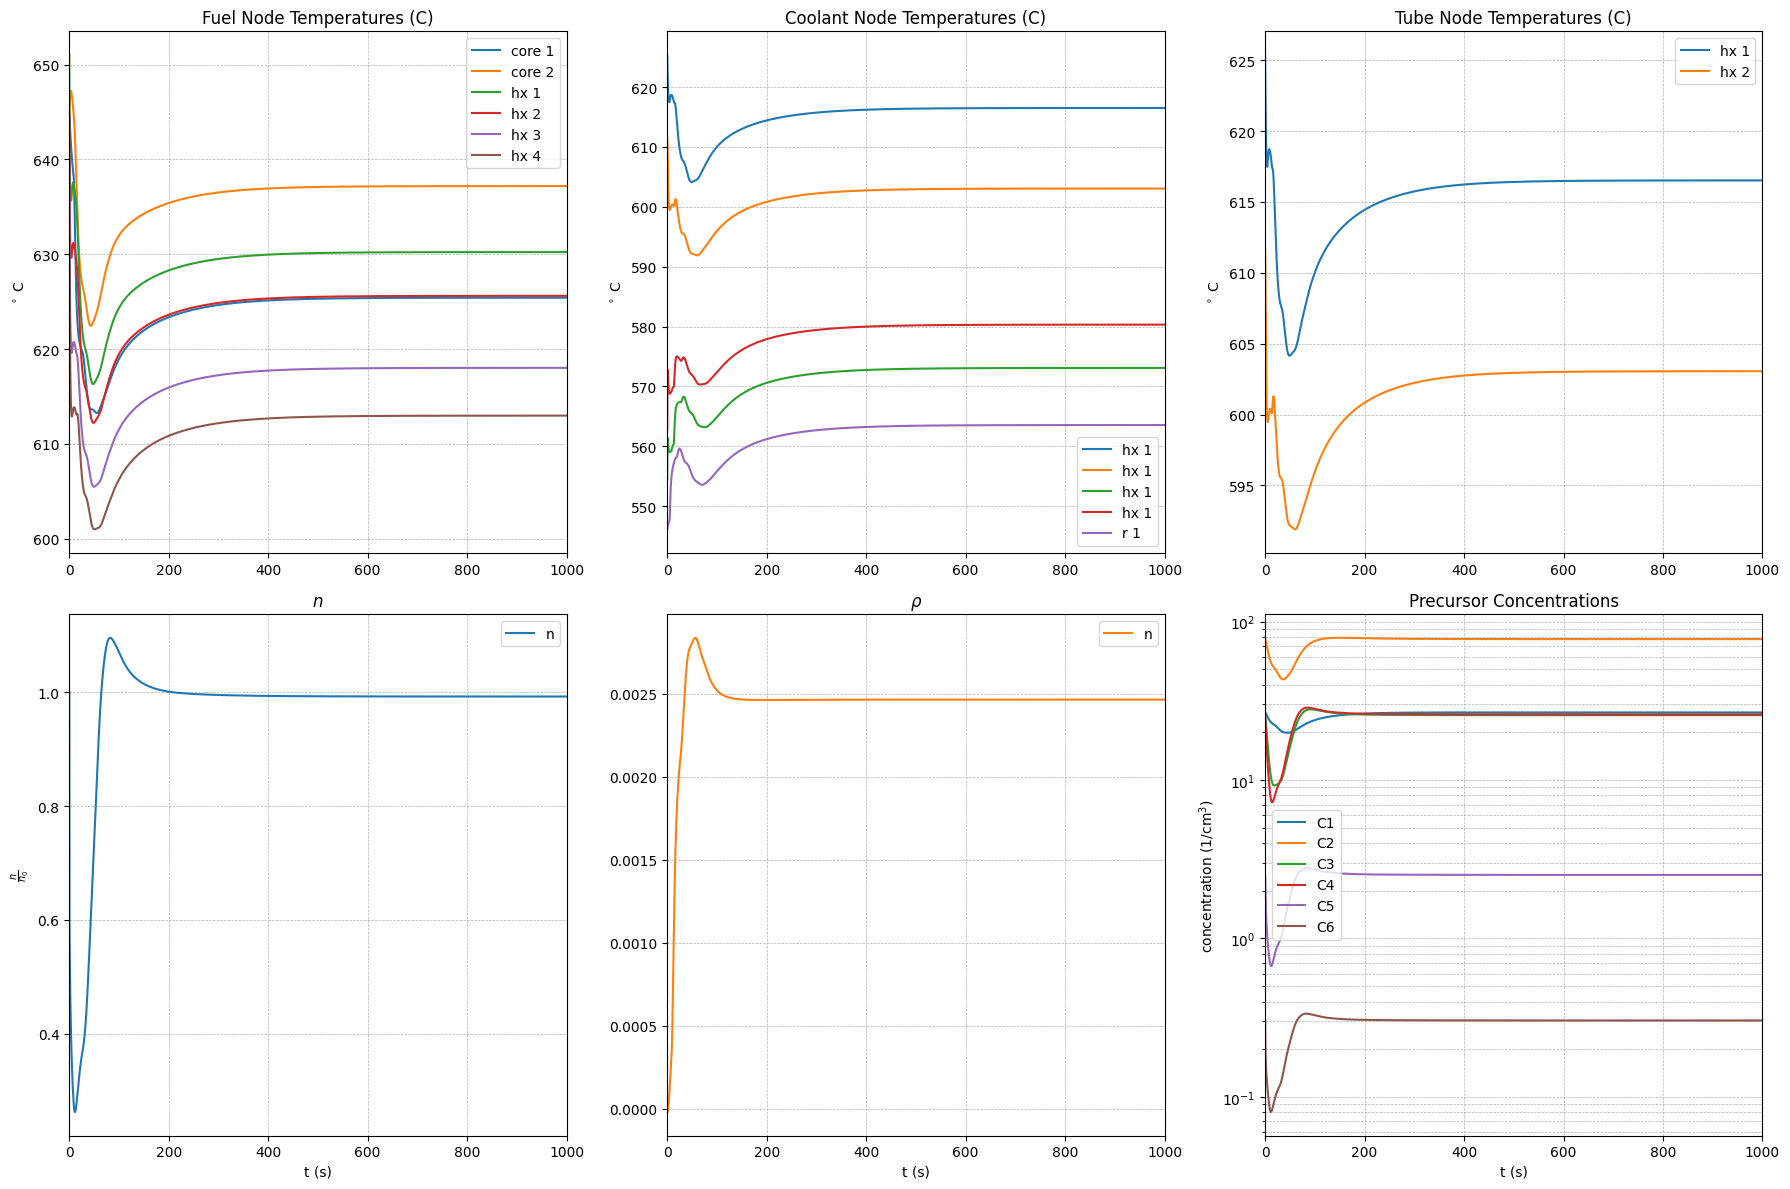

In [6]:
fig,axs = plt.subplots(2,3,figsize=(18,12))

# Set a professional color scheme
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# Function to update the style of each axis
def update_axis_style(ax, title, x_label='', y_label='', x_ticks=True):
    ax.set_xlim([t0,tf])
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Applying the updated style to the subplots
# Fuel temperatures
sol_jit = np.array(sol_jit)
update_axis_style(axs[0, 0], "Fuel Node Temperatures (C)", y_label=r"$^\circ$ C")
axs[0,0].plot(T,[s[20] for s in sol_jit],label="core 1",color=colors[0]) 
axs[0,0].plot(T,[s[21] for s in sol_jit],label="core 2",color=colors[1]) 
axs[0,0].plot(T,[s[2] for s in sol_jit],label="hx 1",color=colors[2])  
axs[0,0].plot(T,[s[3] for s in sol_jit],label="hx 2",color=colors[3])
axs[0,0].plot(T,[s[4] for s in sol_jit],label="hx 3",color=colors[4])
axs[0,0].plot(T,[s[5] for s in sol_jit],label="hx 4",color=colors[5]) 

# Coolant temperatures
update_axis_style(axs[0, 1], "Coolant Node Temperatures (C)", y_label=r"$^\circ$ C")
axs[0, 1].plot(T, sol_jit[:, 6], label=f"hx 1", color=colors[0])
axs[0, 1].plot(T, sol_jit[:, 7], label=f"hx 1", color=colors[1])
axs[0, 1].plot(T, sol_jit[:, 8], label=f"hx 1", color=colors[2])
axs[0, 1].plot(T, sol_jit[:, 9], label=f"hx 1", color=colors[3])
axs[0, 1].plot(T, sol_jit[:, 0], label=f"r 1", color=colors[4])

# Tube node temperatures
update_axis_style(axs[0, 2], "Tube Node Temperatures (C)", y_label=r"$^\circ$ C")
axs[0,2].plot(T,[s[6] for s in sol_jit],label="hx 1",color=colors[0]) 
axs[0,2].plot(T,[s[7] for s in sol_jit],label="hx 2",color=colors[1]) 

# Precursor concentrations
update_axis_style(axs[1, 2], "Precursor Concentrations", x_label="t (s)", y_label=r"concentration (1/cm$^3$)")
for i in range(6):
    axs[1, 2].plot(T, sol_jit[:, i+13], label=f"C{i+1}", color=colors[i])
axs[1, 2].set_yscale("log")

# Multiplication factor temp
update_axis_style(axs[1, 0], r"$n$", x_label="t (s)", y_label=r"$\frac{n}{n_0}$")
axs[1, 0].plot(T, sol_jit[:, 12], label="n", color='tab:blue')

# Reactivity
update_axis_style(axs[1, 1], r"$\rho$", x_label="t (s)")
axs[1, 1].plot(T, sol_jit[:, 22], label="n", color='tab:orange')

# Adding legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()


Define System

Solve with JiTCDDE

Vary temeprature feedback coefficients

In [7]:
# solution vectors
sols = []
sols = [sol_jit]

rho.y0 = 2*rho_0
MSRE.finalize()
sols.append(np.array(MSRE.solve(T)))

AttributeError: 'System' object has no attribute 'finalize'

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(18,12))

# Set a professional color scheme
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# Function to update the style of each axis
def update_axis_style(ax, title, x_label='', y_label='', x_ticks=True):
    ax.set_xlim([t0,tf])
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Applying the updated style to the subplots
# Fuel temperatures
update_axis_style(axs[0, 0], "Fuel Node Temperatures (C)", y_label=r"$^\circ$ C")
axs[0,0].plot(T,[s[20] for s in sols[0]],label="core 1",color=colors[0]) 
axs[0,0].plot(T,[s[21] for s in sols[0]],label="core 2",color=colors[1]) 
axs[0,0].plot(T,[s[2] for s in sols[0]],label="hx 1",color=colors[2])  
axs[0,0].plot(T,[s[3] for s in sols[0]],label="hx 2",color=colors[3])
axs[0,0].plot(T,[s[4] for s in sols[0]],label="hx 3",color=colors[4])
axs[0,0].plot(T,[s[5] for s in sols[0]],label="hx 4",color=colors[5]) 
axs[0,0].plot(T,[s[20] for s in sols[1]],color=colors[0],linestyle="--") 
axs[0,0].plot(T,[s[21] for s in sols[1]],color=colors[1],linestyle="--") 
axs[0,0].plot(T,[s[2] for s in sols[1]],color=colors[2],linestyle="--")  
axs[0,0].plot(T,[s[3] for s in sols[1]],color=colors[3],linestyle="--")
axs[0,0].plot(T,[s[4] for s in sols[1]],color=colors[4],linestyle="--")
axs[0,0].plot(T,[s[5] for s in sols[1]],color=colors[5],linestyle="--") 

# Coolant temperatures
update_axis_style(axs[0, 1], "Coolant Node Temperatures (C)", y_label=r"$^\circ$ C")
axs[0, 1].plot(T, sols[0][:, 6], label=f"hx 1", color=colors[0])
axs[0, 1].plot(T, sols[0][:, 7], label=f"hx 1", color=colors[1])
axs[0, 1].plot(T, sols[0][:, 8], label=f"hx 1", color=colors[2])
axs[0, 1].plot(T, sols[0][:, 9], label=f"hx 1", color=colors[3])
axs[0, 1].plot(T, sols[0][:, 0], label=f"r 1", color=colors[4])
axs[0, 1].plot(T, sols[1][:, 6], color=colors[0],linestyle="--")
axs[0, 1].plot(T, sols[1][:, 7], color=colors[1],linestyle="--")
axs[0, 1].plot(T, sols[1][:, 8], color=colors[2],linestyle="--")
axs[0, 1].plot(T, sols[1][:, 9], color=colors[3],linestyle="--")
axs[0, 1].plot(T, sols[1][:, 0], color=colors[4],linestyle="--")

# Tube node temperatures
update_axis_style(axs[0, 2], "Tube Node Temperatures (C)", y_label=r"$^\circ$ C")
axs[0,2].plot(T,[s[6] for s in sols[0]],label="hx 1",color=colors[0]) 
axs[0,2].plot(T,[s[7] for s in sols[0]],label="hx 2",color=colors[1]) 
axs[0,2].plot(T,[s[6] for s in sols[1]],color=colors[0],linestyle="--") 
axs[0,2].plot(T,[s[7] for s in sols[1]],color=colors[1],linestyle="--") 

# Precursor concentrations
update_axis_style(axs[1, 2], "Precursor Concentrations", x_label="t (s)", y_label=r"concentration (1/cm$^3$)")
for i in range(6):
    axs[1, 2].plot(T, sols[0][:, i+13], label=f"C{i+1}", color=colors[i])
    axs[1, 2].plot(T, sols[1][:, i+13], color=colors[i],linestyle="--")
axs[1, 2].set_yscale("log")

# Multiplication factor temp
update_axis_style(axs[1, 0], r"$n$", x_label="t (s)", y_label=r"$\frac{n}{n_0}$")
axs[1, 0].plot(T, sols[0][:, 12], label="n", color='tab:blue')
axs[1, 0].plot(T, sols[1][:, 12], color='tab:blue',linestyle="--")

# Reactivity
update_axis_style(axs[1, 1], r"$\rho$", x_label="t (s)")
axs[1, 1].plot(T, sols[0][:, 22], label=r"\rho", color='tab:orange')
axs[1, 1].plot(T, sols[1][:, 22], color='tab:orange',linestyle="--")

# Adding legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()


Linearize

In [ ]:
y0 = sols[0][-1]

In [ ]:
n.set_dndt
n.set_dndt(r = rho.y()+rho_ext, beta_eff = beta_t, Lambda = Lam, lam = lam, C = [C1.y(),C2.y(),C3.y(),C4.y(),C5.y(),C6.y()])